In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, timezone
import requests
import os
from time import sleep
import pytz
from scipy.stats import pearsonr
from Functions import check_correlation, analyze_events, wrap_analyze_events, load_data, data_preparation, wrap_analyze_events_multiprocessing, show_output, start_wrap_analyze_events_multiprocessing
from Functions import get_dynamic_volume_avg, get_benchmark_info, show_output_nomultiprocessing, total_function_multiprocessing, download_show_output, getTimeseries, plotTimeseries
import pandas as pd
pd.set_option('display.max_rows', None)
from time import time
from multiprocessing import Process
from multiprocessing import Lock, Pool, Manager
from time import time

/home/alberto/Docker/Trading/analysis/Functions.py:236: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if key is not 'coins' or key is not 'events':
/home/alberto/Docker/Trading/analysis/Functions.py:236: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if key is not 'coins' or key is not 'events':
/home/alberto/Docker/Trading/analysis/Functions.py:795: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if key is not 'coins' or key is not 'events':
/home/alberto/Docker/Trading/analysis/Functions.py:795: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if key is not 'coins' or key is not 'events':


In [ ]:
# TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
list_minutes = [5, 15, 30, 60, 120, 180, 360, 1440]
list_event_buy_volume = [0.65, 0.7, 0.8, 0.9]
list_event_volume = [4,5,6,7,8]
n_processes = 6
LOAD_DATA = False
FREE_LOCK = False

if FREE_LOCK:
    shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA)


In [2]:
# DOWNLOAD AND SHOW OUTPUT FROM TOTAL MULTIPROCESSING
output, info = download_show_output(minimum_event_number=2, mean_threshold=1)
df = pd.DataFrame(output).transpose()
df.sort_values(by=['mean'], ascending=False)
#df.sort_values(by=['lower_bound'], ascending=False)

,mean,std,lower_bound,n_coins,n_events
buy_vol_15m:0.65/vol_3h:7/timeframe:1440/vlty:1,7.59,8.47,-0.88,2.0,2.0
buy_vol_15m:0.65/vol_3h:8/timeframe:1440/vlty:1,7.59,8.47,-0.88,2.0,2.0
buy_vol_15m:0.65/vol_24h:7/timeframe:1440/vlty:1,7.39,8.87,-1.48,1.0,2.0
buy_vol_15m:0.65/vol_6h:8/timeframe:1440/vlty:1,6.83,9.30,-2.47,2.0,2.0
buy_vol_15m:0.65/vol_6h:7/timeframe:1440/vlty:1,6.83,9.30,-2.47,2.0,2.0
buy_vol_5m:0.65/vol_24h:8/timeframe:1440/vlty:1,5.65,9.96,-4.31,1.0,2.0
buy_vol_15m:0.65/vol_24h:6/timeframe:1440/vlty:1,5.09,8.23,-3.14,1.0,3.0
buy_vol_15m:0.65/vol_60m:8/timeframe:1440/vlty:1,4.99,7.98,-2.99,3.0,4.0
buy_vol_15m:0.65/vol_24h:7/timeframe:360/vlty:1,4.40,3.72,0.68,1.0,3.0
buy_vol_15m:0.65/vol_24h:8/timeframe:360/vlty:1,4.37,4.37,0.00,1.0,2.0


In [ ]:
info['buy_vol_3h:0.65/vol_5m:7/timeframe:15/vlty:1']

In [3]:
key = 'buy_vol_3h:0.65/vol_5m:7/timeframe:15/vlty:1'
response = getTimeseries(info, key, check_past=60)


Status Code is :  200


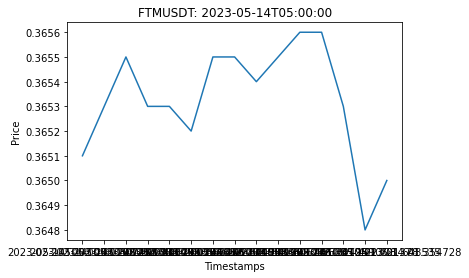

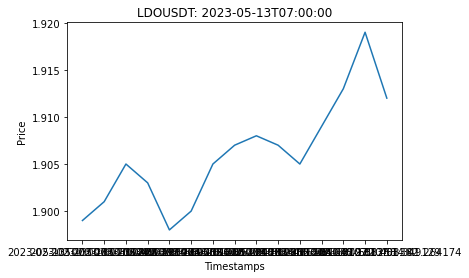

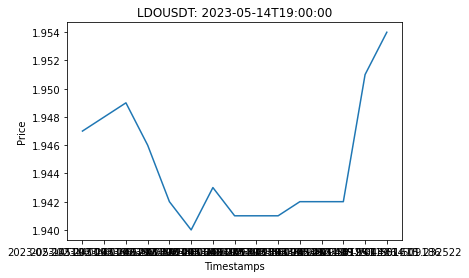

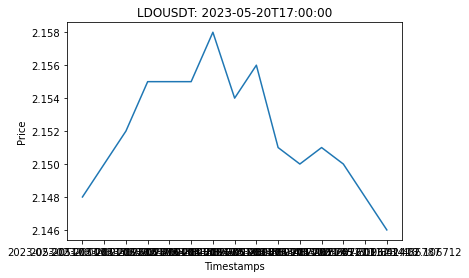

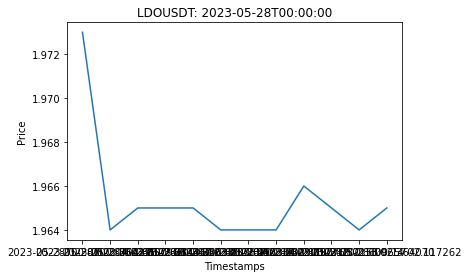

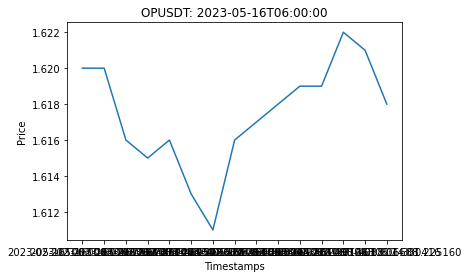

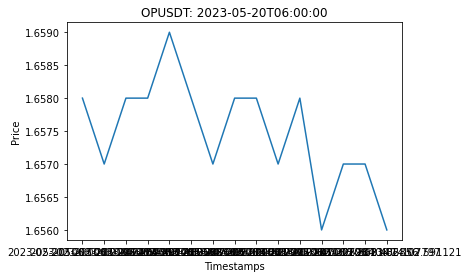

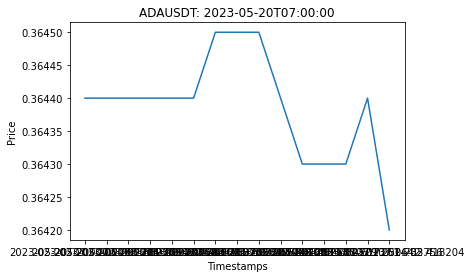

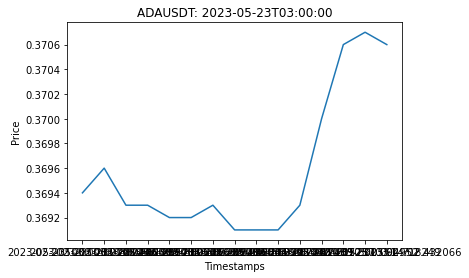

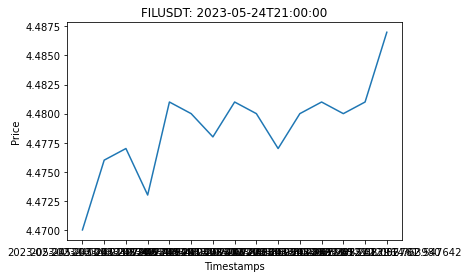

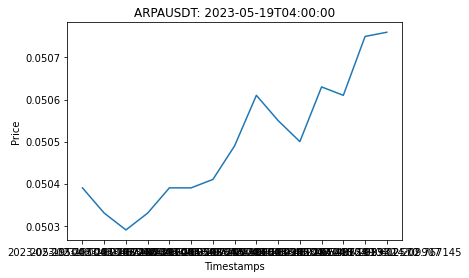

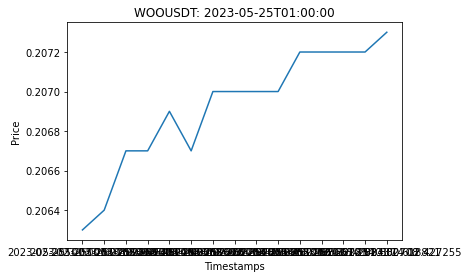

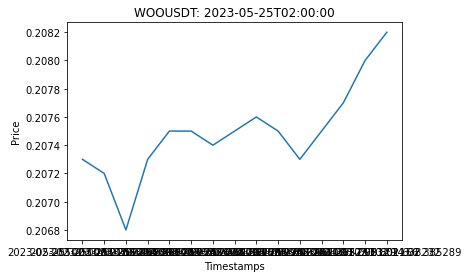

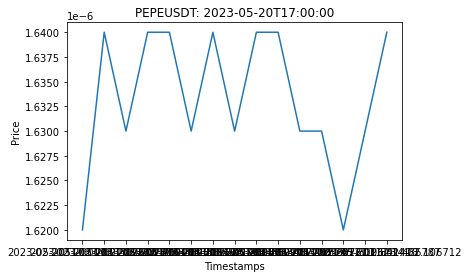

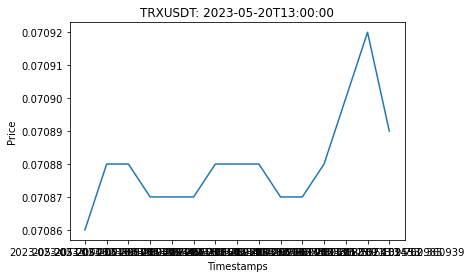

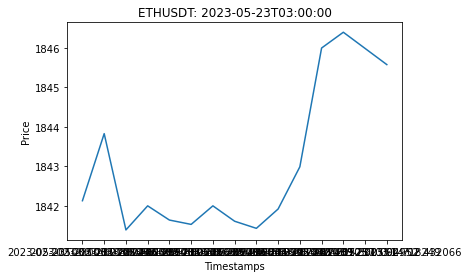

In [4]:
plotTimeseries(response)


